In [2]:
pip install matplotlib

You should consider upgrading via the '/usr/local/bin/python -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [3]:
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPool2D, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.layers import Input
# import tf_slim as slim

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import os
import itertools
import random
%matplotlib inline
np.random.seed(2)

In [4]:
def initializer():
    filter1 = [[0, 0, 0, 0, 0],
               [0, -1, 2, -1, 0],
               [0, 2, -4, 2, 0],
               [0, -1, 2, -1, 0],
               [0, 0, 0, 0, 0]]
    filter2 = [[-1, 2, -2, 2, -1],
               [2, -6, 8, -6, 2],
               [-2, 8, -12, 8, -2],
               [2, -6, 8, -6, 2],
               [-1, 2, -2, 2, -1]]
    filter3 = [[0, 0, 0, 0, 0],
               [0, 0, 0, 0, 0],
               [0, 1, -2, 1, 0],
               [0, 0, 0, 0, 0],
               [0, 0, 0, 0, 0]]
    q = [4.0, 12.0, 2.0]
    filter1 = np.asarray(filter1, dtype=float) / 4
    filter2 = np.asarray(filter2, dtype=float) / 12
    filter3 = np.asarray(filter3, dtype=float) / 2
    filters = [[filter1, filter1, filter1], [filter2, filter2, filter2], [filter3, filter3, filter3]]
    filters = np.einsum('klij->ijlk', filters)
    filters = tf.Variable(filters, dtype=tf.float32)
    return filters

In [5]:
h = 224
w = 224
image_size = (h, w)

# np_arr = lambda img: img.resize(image_size).flatten() / 255.0
np_arr = lambda img: np.array(img.resize(image_size)).flatten() / 255.0

def prepare_image(image_path):
    # img = Image.open(image_path)
    # img = img.resize(image_size)
    # img = np.asarray(img)
    # imgs = np.array(img, dtype=float)
    # input = tf.Variable(imgs, dtype=tf.float32)
    return np_arr(Image.open(image_path))
    # SRM([img])

In [6]:
X = [] # SRM converted images
Y = [] # 0 for fake, 1 for real

In [7]:
def prepare_data(path, cls):
    for dirname, _, filenames in os.walk(path):
        for filename in filenames:
            if filename.endswith('jpg') or filename.endswith('png'):
                try:
                    full_path = os.path.join(dirname, filename)
                    X.append(prepare_image(full_path))
                    Y.append(cls)
                except:
                    pass
                if len(Y) % 500 == 0:
                    print('Processing {} images'.format(len(Y)))

In [8]:
#place authentic
Au_path = '../synthetic/Au'
prepare_data(Au_path, 1)
random.shuffle(X)
# X = X[:2100]
# Y = Y[:2100]
print(len(X), len(Y))

Processing 500 images
Processing 1000 images
Processing 1500 images
Processing 2000 images
Processing 2500 images
Processing 3000 images
Processing 3500 images
Processing 4000 images
Processing 4500 images
Processing 5000 images
Processing 5500 images
Processing 6000 images
Processing 6500 images
Processing 7000 images
Processing 7500 images
Processing 8000 images
8173 8173


In [9]:
#place tampered
Tp_path = '../synthetic/Tp'
prepare_data(Tp_path, 0)
print(len(X), len(Y))

Processing 8500 images
Processing 9000 images
Processing 9500 images
Processing 10000 images
Processing 10500 images
Processing 11000 images
Processing 11500 images
Processing 12000 images
12477 12477


In [10]:
X = np.array(X)
Y = to_categorical(Y, 2)
X = X.reshape(-1, h, w, 3)

x_train, x_val, y_train, y_val = train_test_split(X, Y, test_size = 0.2, random_state=5)

X = X.reshape(-1,1,1,1)

In [11]:
initializer_srm = initializer()

In [13]:
input = Input(shape=(h, w, 3))
op = tf.nn.conv2d(input, initializer_srm, strides=[1, 1, 1, 1], padding='SAME', name='srm-layer')
x = Conv2D(32, 3, padding='valid', activation='relu')(op)
x = Conv2D(32, 3, padding='valid', activation='relu')(x)
x = MaxPool2D(pool_size=2)(x)
x = BatchNormalization()(x)
# x = Dropout(0.25)(x)

x = Conv2D(64, 3, padding='valid', activation='relu')(x)
x = BatchNormalization()(x)
x = Conv2D(64, 3, padding='valid', activation='relu')(x)
x = MaxPool2D(pool_size=2)(x)
x = BatchNormalization()(x)
# x = Dropout(0.25)(x)

x = Conv2D(128, 3, padding='valid', activation='relu')(x)
x = BatchNormalization()(x)
x = Conv2D(128, 3, padding='valid', activation='relu')(x)
x = MaxPool2D(pool_size=2)(x)
x = BatchNormalization()(x)

# x = Conv2D(256, 3, padding='valid', activation='relu')(x)
# x = BatchNormalization()(x)
# x = Conv2D(256, 3, padding='valid', activation='relu')(x)
# x = MaxPool2D(pool_size=2)(x)
# x = BatchNormalization()(x)

# x = Conv2D(512, 3, padding='valid', activation='relu')(x)
# x = BatchNormalization()(x)
# x = Conv2D(512, 3, padding='valid', activation='relu')(x)
# x = MaxPool2D(pool_size=2)(x)
# x = BatchNormalization()(x)

x = Flatten()(x)
x = Dense(256, activation='relu')(x)
x = BatchNormalization()(x)
# x = Dropout(0.5)(x)
output = Dense(2, activation='softmax')(x)

model = tf.keras.Model(inputs=[input], outputs=[output])
model.summary()

[2021-05-05 02:27:10.262 tensorflow-2-3-gp-ml-g4dn-12xlarge-1be1fa3f01e6a5645cff1d084b39:1047 INFO utils.py:27] RULE_JOB_STOP_SIGNAL_FILENAME: None
[2021-05-05 02:27:10.285 tensorflow-2-3-gp-ml-g4dn-12xlarge-1be1fa3f01e6a5645cff1d084b39:1047 INFO profiler_config_parser.py:102] Unable to find config at /opt/ml/input/config/profilerconfig.json. Profiler is disabled.
Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
tf_op_layer_srm-layer (Tenso [(None, 224, 224, 3)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 222, 222, 32)      896       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 220, 220, 32)      9248      
_________________

In [14]:
epochs = 50
batch_size = 32
init_lr = 1e-4
# optimizer = Adam(lr = init_lr)
optimizer = Adam(lr = init_lr, decay = init_lr/epochs)

early_stopping = EarlyStopping(monitor='val_accuracy', min_delta=0,patience=10, verbose=0, mode='auto')

checkpoint_filepath = 'srm_synthetic_8/checkpoint'
model_checkpoint_callback = ModelCheckpoint(filepath=checkpoint_filepath, save_weights_only=True, monitor='val_accuracy', mode='max', save_best_only=True)

model.compile(optimizer = optimizer, loss = 'binary_crossentropy', metrics=['accuracy'])

In [15]:
history = model.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, validation_data=(x_val, y_val), callbacks=[early_stopping, model_checkpoint_callback])

Epoch 1/50
312/312 [==============================] - ETA: 0s - loss: 0.4692 - accuracy: 0.8242WARNING:tensorflow:Callbacks method `on_test_batch_end` is slow compared to the batch time (batch time: 0.0066s vs `on_test_batch_end` time: 0.0252s). Check your callbacks.


312/312 [==============================] - 44s 142ms/step - loss: 0.4692 - accuracy: 0.8242 - val_loss: 1.3642 - val_accuracy: 0.6554
Epoch 2/50
312/312 [==============================] - 42s 134ms/step - loss: 0.3052 - accuracy: 0.8776 - val_loss: 0.4637 - val_accuracy: 0.8542
Epoch 3/50
312/312 [==============================] - 38s 121ms/step - loss: 0.2452 - accuracy: 0.9021 - val_loss: 0.4706 - val_accuracy: 0.8305
Epoch 4/50
312/312 [==============================] - 38s 122ms/step - loss: 0.1989 - accuracy: 0.9271 - val_loss: 0.4965 - val_accuracy: 0.8486
Epoch 5/50
312/312 [==============================] - 38s 122ms/step - loss: 0.1626 - accuracy: 0.9415 - val_loss: 0.5985 - val_accuracy: 0.8149
Epoch 6/50
312/312 [==============================] - 38s 123ms/step - loss: 0.1503 - accuracy: 0.9461 - val_loss: 0.5397 - val_accuracy: 0.8201
Epoch 7/50
312/312 [==============================] - 39s 124ms/step - loss: 0.1384 - accuracy: 0.9515 - val_loss: 0.8005 - val_accuracy: 0.7

In [17]:
X_test_set = [] # SRM converted images
Y_test_set = [] # 0 for fake, 1 for real

In [18]:
def prepare_data(path, cls):
    for dirname, _, filenames in os.walk(path):
        for filename in filenames:
            if filename.endswith('jpg') or filename.endswith('png'):
                try:
                    full_path = os.path.join(dirname, filename)
                    X_test_set.append(prepare_image(full_path))
                    Y_test_set.append(cls)
                except:
                    pass
                if len(Y_test_set) % 500 == 0:
                    print('Processing {} images'.format(len(Y_test_set)))

In [19]:
#place authentic
# synthetic_test/Au
Au_path = '../synthetic_test/Au'
prepare_data(Au_path, 1)
random.shuffle(X_test_set)
# X = X[:2100]
# Y = Y[:2100]
print(len(X_test_set), len(Y_test_set))

Processing 500 images
790 790


In [20]:
#place tampered
Tp_path = '../synthetic_test/Tp'
prepare_data(Tp_path, 0)
print(len(X_test_set), len(Y_test_set))

Processing 1000 images
1190 1190


In [21]:
X_test_set = np.array(X_test_set)
Y_test_set = to_categorical(Y_test_set, 2)
X_test_set = X_test_set.reshape(-1, h, w, 3)

x_test, x_test2, y_test, y_test2 = train_test_split(X_test_set, Y_test_set, test_size = 0.2, random_state=5)

# X_test = X_test.reshape(-1,1,1,1)

In [22]:
from sklearn.metrics import average_precision_score

predictions = model.predict(x_test)
average_precision = average_precision_score(y_test, predictions)

In [23]:
average_precision

0.8406762487084554

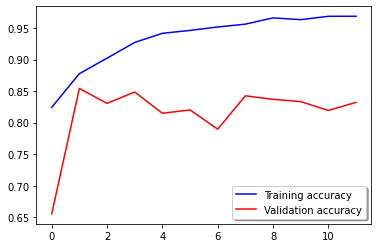

In [24]:
plt.plot(history.history['accuracy'], color='b', label="Training accuracy")
plt.plot(history.history['val_accuracy'], color='r',label="Validation accuracy")
legend = plt.legend(loc='best', shadow=True)
plt.savefig("srm.png", bbox_inches='tight', pad_inches=0)

In [44]:
from tensorflow.keras.models import load_model

model_1 = model.load_weights('srm_synthetic_7/checkpoint.hdf5')

In [1]:
# predictions = model_1.predict(x_test)
# average_precision = average_precision_score(y_test, predictions)